# Project-6: Transformers in production

**Case Description**

In this notebook we will reduce model size by distillation and quantization methods

**Task**
Check metric results on test data for fine-tuning BERT model before and after applying Distillation & Quantification methods.

**Dataset**:
[AG news dataset](https://huggingface.co/datasets/fancyzhx/ag_news)

**ML Task**: Model compression via distillation and quantization

Training on GPU

# 0. Install and Import

In [1]:
%%capture
!pip install transformers # the huggingface library containing the general-purpose architectures for NLP
!pip install datasets # the huggingface library containing datasets and evaluation metrics for NLP
!pip install evaluate

In [2]:
import os
import random
import numpy as np
import pandas as pd

#Libs for visualization
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# pytorch libraries
import torch
import evaluate
import transformers
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, pipeline
from datasets import load_dataset, DatasetDict
from evaluate import evaluator

import warnings
warnings.filterwarnings("ignore")

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"

In [3]:
# Fixing RANDOM_SEED to make experiment repetable
RANDOM_SEED = 42

# Set random seeds
def set_seed(seed):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    np.random.seed(seed)
    random.seed(seed)
#     tf.random.set_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    
set_seed(RANDOM_SEED)

In [4]:
# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

In [5]:
# If we have a GPU available, we'll set our device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 1. Data Loading: dataset exploration

AG News (AG's News Corpus) is a subdataset of AG's corpus of news articles constructed by assembling titles (labels) and description fields of articles from the 4 largest classes (“World”, “Sports”, “Business”, “Sci/Tech”) of AG's Corpus.

The AG News contains 120,000 training and 7,600 test samples per class.

In [6]:
# Load the AG news dataset - https://huggingface.co/datasets/fancyzhx/ag_news
dataset_ag = load_dataset("fancyzhx/ag_news")
dataset_ag

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

There are several important fields here:

* **text**: description fields of articles.
* **label**: 4 clasess of articles.

In [7]:
# Look at the examples in train dataset
print("Label: ", dataset_ag["train"][1]["label"])
print("\nText: ", dataset_ag["train"][1]["text"])

Label:  2

Text:  Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.


The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

It means that as a key metric I can choose **accuracy_score** because our data is balanced.

## Preprocess dataset

* Create train/validation/ test sets

`train/ validation / test sets`

In [8]:
"""
Create a validation set (10%) for finding the model with best generalizability
"""
train_val_dataset = dataset_ag["train"].train_test_split(test_size=0.1, seed=RANDOM_SEED)
train_val_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 108000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12000
    })
})

In [9]:
"""
Create datasets for fine-tuning
"""
datasets = DatasetDict({
    'train': train_val_dataset['train'],
    'validation': train_val_dataset['test'],
    'test': dataset_ag['test']
})
datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [10]:
"""
Get class label information from dataset
"""
num_labels = datasets["train"].features["label"].num_classes

id2label = {}
label2id = {}

for label_id, label in enumerate(datasets["train"].features["label"].names):
    id2label[label_id] = label
    label2id[label] = label_id

print(f"Number of labels: {num_labels}")
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

Number of labels: 4
id2label: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
label2id: {'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}


In [11]:
# get random integers in the range of 0 to train_dataset_length
example_indices = [random.randrange(len(datasets["train"])) for _ in range(3)]
example_indices

[83810, 14592, 3278]

In [12]:
for i in example_indices:
    text = datasets['train']['text'][i]
    label_id = datasets['train']['label'][i]
    label = id2label[label_id]
    
    print(f"TEXT[{i}]: {text}")
    print(f"LABEL[{i}]: {label} ({label_id})")
    print()

TEXT[83810]: Hopes fade for China mine victims Rescuers express mounting fears for 86 people still missing after a gas explosion in a China coal mine killed 62.
LABEL[83810]: World (0)

TEXT[14592]: Notebook: Breeders #39; Cup gives title hope to several The landscape has changed since Smarty Jones #39; meteoric rise from obscurity to stardom last spring, when the colt from Pennsylvania appeared to be 
LABEL[14592]: Sports (1)

TEXT[3278]: Max Table size in MySQL \\It turns out that MySQL  has a terrible upper limit on the max MyISAM table\size.  It appears that innodb doesn't have this problem.\\Jeremy talks about it over on his blog \\"When this happens, the first reaction I hear is "You never told me that MySQL\has a 4GB limit! What am I going to do?" Amusingly, I usually do describe the\limit when I discuss the possibility of using MySQL with various groups--they\often forget or underestimate the impact it will have. Putting that aside, the\problem is easily fixed, as that page exp

***

# 2. Model training

This part consists of 3 examples of model training:
- fine-tuned BERT base model
- distilled BERT model (DistilBert, TinyBERT, MiniLM)
- quantized BERT model

In [13]:
"""
Function to get Model size
"""
def print_size_of_model(model):
    torch.save(model.state_dict(), 'temp.p')
    print('Size (MB): ',
         np.round(os.path.getsize('temp.p')/1e6, 2))
    os.remove('temp.p')

# def get_layer_sizes(model):
#     layer_sizes = {}
#     total_size = 0

#     for name, param in model.named_parameters():
#         layer_size = param.numel() * param.element_size()  # numel() returns the number of elements, element_size() returns the size in bytes of each element
#         total_size += layer_size
#         layer_sizes[name] = (param.numel(), layer_size, param.dtype)

#     return layer_sizes, total_size

In [14]:
def tokenize(dataset,tokenizer):
    """
    Function to use map to tokenize entire dataset and batch building
    """
    # tokenize and truncate dataset by batch, while removing unused column
    tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True),
                                     batched=True,
                                     remove_columns=["text"])

    # rename for multiclass fine-tuning
    tokenized_ds = tokenized_dataset.rename_column("label", "labels")

    # set format to pytorch
    tokenized_ds.set_format(type="torch")

    return tokenized_ds

## 2.1 Fine-tuning BERT base model

In [15]:
"""
Loading the tokenizer corresponding to a pretrained BERT model.
Using the same tokenizer as the pretrained model is important because I want to make sure the text is split in the same way.
"""
# Load the pre-trained BERT model and tokenizer - get fast BERT tokenizer
model_checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
"""
Call tokenizer on the first row of text in the dataset
"""
tokenizer(datasets["train"][0]["text"])

{'input_ids': [101, 13905, 1998, 4963, 1999, 2235, 2845, 2237, 2044, 6859, 2022, 14540, 2319, 1010, 3607, 1006, 26665, 1007, 1011, 1996, 4288, 1997, 2062, 2084, 13710, 2336, 1010, 3008, 1998, 5089, 2076, 1996, 6703, 2203, 2000, 1037, 5187, 1011, 3178, 2082, 6859, 2187, 4510, 1037, 2155, 22154, 1999, 1996, 2235, 2845, 2237, 1997, 2022, 14540, 2319, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

The tokenizer returns a dictionary with three items:

* **input_ids**: the numbers representing the tokens in the text.
* **token_type_ids**: indicates which sequence a token belongs to if there is more than one sequence.
* **attention_mask**: indicates whether a token should be masked or not.

These values are actually the model inputs.

In [17]:
tokenized_datasets = tokenize(datasets,tokenizer)

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [18]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7600
    })
})

There are 4 columns:

* **labels**: the true class label that corresponds to this news
* **input_ids**: the token ids based on the tokenizer
* **token_type_ids**: the binary mask identifying the two types of sequence in the model
* **attention_mask**: the attention boolean map of token ids

In [19]:
"""
Apply dynamic padding strategy to pad our texts
Instead of padding the whole dataset to the longest sequence, we will pad to the longest sequence in the current batch

In order to use dynamic padding in combination with the Trainer:
- firstly, specifying truncation=True when preprocessing the dataset,
- after using the DataCollatorWithPadding when defining the data loaders, which will dynamically pad the batches
"""
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=4).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
print_size_of_model(model)

Size (MB):  438.01


In [22]:
# Set values for model and train
training_args = TrainingArguments(
    output_dir="./results_bert",
    # important as the standard setting of 500 creates too much data
    save_strategy = 'epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    group_by_length=True # grouping together samples of the same length - smart batching
)

trainer_ft_bert = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [23]:
os.environ["WANDB_DISABLED"] = "true"
torch.cuda.empty_cache()

# 29/01/2025
%time trainer_ft_bert.train()

Step,Training Loss
500,0.348700
1000,0.232300
1500,0.206800
2000,0.198900
2500,0.187600
3000,0.177500


CPU times: user 19min 42s, sys: 18.1 s, total: 20min
Wall time: 16min 57s


TrainOutput(global_step=3375, training_loss=0.21926742666739005, metrics={'train_runtime': 977.4549, 'train_samples_per_second': 110.491, 'train_steps_per_second': 3.453, 'total_flos': 3146733172058112.0, 'train_loss': 0.21926742666739005, 'epoch': 1.0})

## Evaluate

In [24]:
preds_bert = trainer_ft_bert.predict(tokenized_datasets['test'])
print(preds_bert.predictions.shape)

(7600, 4)


In [25]:
# Clean the predictions into an interpretable form.
preds_flat = [np.argmax(x) for x in preds_bert[0]]

len(preds_flat)

7600

`Metrics`

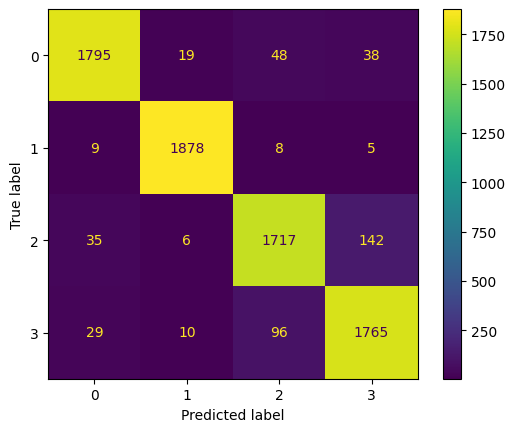

In [26]:
cm = confusion_matrix(tokenized_datasets['test']['labels'], preds_flat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

In [27]:
acc = accuracy_score(tokenized_datasets['test']['labels'], preds_flat)

print(f'Accuracy BERT_base: {np.round(acc, 3)}')

Accuracy BERT_base: 0.941


#### We get average accuracy_score **0.94** - after 1 epoch (16 minutes)!

In [28]:
"""
Saving the model for future use
"""
trainer_ft_bert.save_model("./BERT_base-AG-NEWS")

## 2.2 Distillation
- DistilBert
- TinyBERT
- MobileBert

### DistilBert

In [29]:
model_checkpoint_distil = "distilbert-base-uncased"

In [30]:
tokenizer_distil = AutoTokenizer.from_pretrained(model_checkpoint_distil)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [31]:
tokenized_ds_distil = tokenize(datasets,tokenizer_distil)

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [32]:
"""
Setting up the Data Collator object
- The data collator is what will be responsible for the batches that we will be using to train the model (batch training)
- It will be of the same type of the data that's being given to it (In this case, Input IDs, Attention Mask, and such...)
"""
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_distil)

In [33]:
# Loading in the HuggingFace Transformer Model
model_distil = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_distil, num_labels=4).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
print_size_of_model(model_distil)

Size (MB):  267.86


In [35]:
"""
Fine-tuning the transformer model with our data
"""
# Define Training Arguments and Trainer
training_args = TrainingArguments(
    output_dir="./results_distil",
    save_strategy = 'epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    num_train_epochs=1,
    weight_decay=0.01,
    group_by_length=True
)


trainer_distil = Trainer (
    model=model_distil,
    args=training_args,
    train_dataset=tokenized_ds_distil['train'],
    eval_dataset=tokenized_ds_distil['validation'],
    tokenizer=tokenizer_distil,
    data_collator=data_collator,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [36]:
os.environ["WANDB_DISABLED"] = "true"
torch.cuda.empty_cache()

#29/01/25
%time trainer_distil.train()

Step,Training Loss
500,0.376400
1000,0.242300
1500,0.221600
2000,0.210400
2500,0.202100
3000,0.189800


CPU times: user 9min 40s, sys: 11.7 s, total: 9min 52s
Wall time: 8min 57s


TrainOutput(global_step=3375, training_loss=0.23362364818431713, metrics={'train_runtime': 502.0003, 'train_samples_per_second': 215.139, 'train_steps_per_second': 6.723, 'total_flos': 1584300359706624.0, 'train_loss': 0.23362364818431713, 'epoch': 1.0})

## Evaluate

In [37]:
preds = trainer_distil.predict(tokenized_ds_distil['test'])

In [38]:
preds_flat = [np.argmax(x) for x in preds[0]]

len(preds_flat)

7600

In [39]:
acc = accuracy_score(tokenized_datasets['test']['labels'], preds_flat)

print(f'Accuracy DistilBERT: {np.round(acc, 3)}')

Accuracy DistilBERT: 0.939


#### We get average fscore **0.939** - after 1 epoch (8 minutes)!

In [40]:
"""
Saving the model for future use
"""
trainer_distil.save_model("./DistilBERT-AG-NEWS")

***

### TinyBERT

In [41]:
model_checkpoint_tiny = "huawei-noah/TinyBERT_General_4L_312D"

In [42]:
tokenizer_tiny = AutoTokenizer.from_pretrained(model_checkpoint_tiny)

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [43]:
tokenized_ds_tiny = tokenize(datasets,tokenizer_tiny)

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [44]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_tiny)

model_tiny = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_tiny, num_labels=4).to(device)

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
print_size_of_model(model_tiny)

Size (MB):  57.43


In [46]:
# Slightly modified training Arguments
training_args = TrainingArguments(
    output_dir="./results_tiny",
    save_strategy = 'epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    num_train_epochs=1,
    weight_decay=0.01,
    group_by_length=True
)


trainer_tiny = Trainer (
    model=model_tiny,
    args=training_args,
    train_dataset=tokenized_ds_tiny['train'],
    eval_dataset=tokenized_ds_tiny['validation'],
    tokenizer=tokenizer_tiny,
    data_collator=data_collator,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [47]:
os.environ["WANDB_DISABLED"] = "true"
torch.cuda.empty_cache()

#29/01/25
%time trainer_tiny.train()

Step,Training Loss
500,0.729300
1000,0.372100
1500,0.327800
2000,0.315500
2500,0.293300
3000,0.287100


CPU times: user 3min 21s, sys: 5.98 s, total: 3min 26s
Wall time: 2min 55s


TrainOutput(global_step=3375, training_loss=0.3750506049262153, metrics={'train_runtime': 134.264, 'train_samples_per_second': 804.385, 'train_steps_per_second': 25.137, 'total_flos': 171510224320512.0, 'train_loss': 0.3750506049262153, 'epoch': 1.0})

## Evaluate

In [48]:
preds = trainer_tiny.predict(tokenized_ds_tiny['test'])

In [49]:
preds_flat = [np.argmax(x) for x in preds[0]]
len(preds_flat)

7600

In [50]:
acc = accuracy_score(tokenized_datasets['test']['labels'], preds_flat)

print(f'Accuracy TinyBERT: {np.round(acc, 3)}')

Accuracy TinyBERT: 0.907


#### We get average fscore **0.91** - after 1 epoch (2 minutes)!

In [51]:
"""
Saving the model for future use
"""
trainer_tiny.save_model("./TinyBERT-AG-NEWS")

***

### MiniLM

In [52]:
model_checkpoint_MiniLM = "microsoft/MiniLM-L12-H384-uncased"

In [53]:
tokenizer_MiniLM = AutoTokenizer.from_pretrained(model_checkpoint_MiniLM)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [54]:
tokenized_ds_MiniLM = tokenize(datasets, tokenizer_MiniLM)

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [55]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_MiniLM)

In [56]:
model_MiniLM = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_MiniLM, num_labels=4).to(device)

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
print_size_of_model(model_MiniLM)

Size (MB):  133.51


In [58]:
# Define Training Arguments and Trainer
training_args = TrainingArguments(
    output_dir="./results_MiniLM",
    save_strategy = 'epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    num_train_epochs=1,
    weight_decay=0.01,
    group_by_length=True
)


trainer_MiniLM = Trainer (
    model=model_MiniLM,
    args=training_args,
    train_dataset=tokenized_ds_MiniLM['train'],
    eval_dataset=tokenized_ds_MiniLM['validation'],
    tokenizer=tokenizer_MiniLM,
    data_collator=data_collator,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [59]:
os.environ["WANDB_DISABLED"] = "true"
torch.cuda.empty_cache()

#29/01/25
%time trainer_MiniLM.train()

Step,Training Loss
500,0.550900
1000,0.302500
1500,0.265700
2000,0.247000
2500,0.231800
3000,0.212900


CPU times: user 7min 19s, sys: 13 s, total: 7min 32s
Wall time: 6min 6s


TrainOutput(global_step=3375, training_loss=0.2916997296368634, metrics={'train_runtime': 325.6069, 'train_samples_per_second': 331.688, 'train_steps_per_second': 10.365, 'total_flos': 787833205254144.0, 'train_loss': 0.2916997296368634, 'epoch': 1.0})

## Evaluate

In [60]:
preds = trainer_MiniLM.predict(tokenized_ds_MiniLM['test'])

preds_flat = [np.argmax(x) for x in preds[0]]
len(preds_flat)

7600

In [61]:
acc = accuracy_score(tokenized_datasets['test']['labels'], preds_flat)

print(f'Accuracy MiniLM: {np.round(acc, 3)}')

Accuracy MiniLM: 0.932


#### We get average fscore **0.93** - after 1 epoch (5 minutes)!

In [62]:
"""
Saving the model for future use
"""
trainer_MiniLM.save_model("./MiniLMBERT-AG-NEWS")

## 2.3 Quantization
`It might cause a dip in performance metrics`
- Dynamic Quantization
- Static Quantization
- Quantization aware training
Firstly, load libs for Quantization

In [63]:
%%capture
# !pip install optimum
# !pip install onnx
!pip install optimum[onnxruntime-gpu]
!pip install onnxruntime-training
!pip install torch-ort

In [64]:
%%capture
!python -m torch_ort.configure

In [65]:
import onnxruntime as ort
from functools import partial
from optimum.onnxruntime import ORTModelForSequenceClassification, ORTQuantizer, ORTTrainer, ORTTrainingArguments
from optimum.onnxruntime.configuration import AutoQuantizationConfig, AutoCalibrationConfig

ort.get_device()

'GPU'

In [66]:
"""
Defining trained BERT_base model as model_checkpoint because I compare base model result with the other versions
"""
model_checkpoint = './BERT_base-AG-NEWS'
save_directory = 'tmp/onnx/'

In [67]:
"""
Tokenize test ds with text and labels columns for further testing
"""
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# tokenize and truncate dataset by batch, while removing unused column
tokenized_test = datasets['test'].map(lambda x: tokenizer(x["text"], truncation=True),
                                 batched=True)

# rename for multiclass fine-tuning
tokenized_test_ds = tokenized_test.rename_column("label", "labels")

# set format to pytorch
tokenized_test_ds.set_format(type="torch")

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [68]:
"""
Dynamic Quantization
"""
# Load a model from transformers and export it to ONNX
ort_model = ORTModelForSequenceClassification.from_pretrained(model_checkpoint, export=True)

# Save the ONNX model and tokenizer
ort_model.save_pretrained(save_directory)

# Define the quantization methodology
qconfig = AutoQuantizationConfig.arm64(is_static=False, per_channel=False) # is_static is the param to choose dynamic/static quantization method
quantizer = ORTQuantizer.from_pretrained(ort_model)

# Apply dynamic quantization on the model
quantizer.quantize(save_dir=save_directory, quantization_config=qconfig)

# load quantized model
quant_model = ORTModelForSequenceClassification.from_pretrained(save_directory, file_name="model_quantized.onnx")
# pass sentence through pipeline
dynamic_pipe = pipeline("text-classification", model=quant_model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


There is some mismatching at the next steps of code snippet that's why I skipped 'device' argument (GPU/CPU).

In [69]:
print('Size (MB): ', np.round(os.path.getsize('tmp/onnx/model_quantized.onnx')/1e6))

Size (MB):  110.0


In [70]:
task_evaluator = evaluator("text-classification")

eval_results_dynamic = task_evaluator.compute(
    model_or_pipeline=dynamic_pipe,
    tokenizer=tokenizer,
    metric='accuracy',
    input_column="text",
    label_column="labels",
    data=tokenized_test_ds,
    label_mapping=quant_model.config.label2id,
)

print(eval_results_dynamic)

{'accuracy': 0.935921052631579, 'total_time_in_seconds': 317.098838808, 'samples_per_second': 23.967290541236324, 'latency_in_seconds': 0.04172353142210526}


In [71]:
"""
Static Quantization
"""
# set_static_qantization options
onnx_model = ORTModelForSequenceClassification.from_pretrained(model_checkpoint, export=True)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
quantizer = ORTQuantizer.from_pretrained(onnx_model)
qconfig = AutoQuantizationConfig.arm64(is_static=True, per_channel=False)

# tokenizing cycle
def preprocess_fn(ex, tokenizer):
    return tokenizer(ex["text"])
    
# load calibration dataset
calibration_dataset = quantizer.get_calibration_dataset(
    "ag_news",
    # dataset_config_name="sst",
    preprocess_function=partial(preprocess_fn, tokenizer=tokenizer),
    num_samples=50,
    dataset_split="train"
    )

# create calibration config(basic)
calibration_config = AutoCalibrationConfig.minmax(calibration_dataset)

# calibrating quantizer
ranges = quantizer.fit(
    dataset=calibration_dataset,
    calibration_config=calibration_config,
    operators_to_quantize=qconfig.operators_to_quantize
)

# quantizing
model_quantized_path = quantizer.quantize(
    save_dir=save_directory+'static_quantized.onnx',
    calibration_tensors_range=ranges,
    quantization_config=qconfig
    )

# pass sentence through pipeline
static_quant_model = ORTModelForSequenceClassification.from_pretrained(model_quantized_path)
static_pipe = pipeline("text-classification", model=static_quant_model, tokenizer=tokenizer)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [72]:
print('Size (MB): ', np.round(os.path.getsize('tmp/onnx/static_quantized.onnx')/1e6, 3))

Size (MB):  0.004


In [73]:
eval_results_static = task_evaluator.compute(
    model_or_pipeline=static_pipe,
    tokenizer=tokenizer,
    metric='accuracy',
    input_column="text",
    label_column="labels",
    data=tokenized_test_ds,
    label_mapping=static_quant_model.config.label2id,
)

print(eval_results_static)

{'accuracy': 0.9303947368421053, 'total_time_in_seconds': 417.4914435290002, 'samples_per_second': 18.20396589630245, 'latency_in_seconds': 0.05493308467486845}


In [74]:
"""
Quantization aware training
"""
# Load unpretrained model and quantize while training is going.
# I will take dataset which I already used with distiled models, and the same model params
model_qat = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4).to(device)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Dataset preprocessing
tokenized_ds = tokenize(datasets, tokenizer=tokenizer)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define training arguments
training_args = ORTTrainingArguments(
    output_dir="./results_quantized",
    save_strategy = 'epoch',
    optim="adamw_ort_fused",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    num_train_epochs=1,
    weight_decay=0.01,
    group_by_length=True
)

# Create ONNX Runtime Trainer
trainer_quantized_model = ORTTrainer(
    model=model_qat,
    args=training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator   
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [75]:
# Train the model while applying quantization
os.environ["WANDB_DISABLED"] = "true"
torch.cuda.empty_cache()

#29/01/25
%time trainer_quantized_model.train()

Step,Training Loss
500,0.357700
1000,0.232600
1500,0.206800
2000,0.196200
2500,0.187600
3000,0.178700


CPU times: user 18min 38s, sys: 16.5 s, total: 18min 54s
Wall time: 15min 48s


TrainOutput(global_step=3375, training_loss=0.22043081552010996, metrics={'train_runtime': 907.712, 'train_samples_per_second': 118.98, 'train_steps_per_second': 3.718, 'total_flos': 3146733172058112.0, 'train_loss': 0.22043081552010996, 'epoch': 1.0})

In [76]:
# Export the quantized model and save it
trainer_quantized_model.save_model("./model_qat_aware_training")

In [78]:
print('Size (MB): ', os.path.getsize('model_qat_aware_training')/1e6)

Size (MB):  0.004096


In [79]:
"""
Evaluation
"""
preds = trainer_quantized_model.predict(tokenized_ds['test'])

preds_flat = [np.argmax(x) for x in preds[0]]
len(preds_flat)

7600

In [80]:
acc = accuracy_score(tokenized_datasets['test']['labels'], preds_flat)
print(f'Accuracy Quantization aware training: {np.round(acc, 3)}')

Accuracy Quantization aware training: 0.941


# 3. Results

In [81]:
result_df = pd.DataFrame(
    {'Model name': ['Bert', 'Distil_Bert', 'Tiny_Bert', 'MiniLM', 'Dynamic_Quantization', 'Static_Quantization', 'Quantization_aware_training'],
     'Accuracy score on test data': ['0.94', '0.938', '0.91', '0.93', '0.935', '0.93', '0.94'],
     'Model size (MiB)': ['438', '267.86', '57.43', '133.51', '110', '0.004', '0.004']
    }
)

display(result_df)

,Model name,Accuracy score on test data,Model size (MiB)
0,Bert,0.94,438
1,Distil_Bert,0.938,267.86
2,Tiny_Bert,0.91,57.43
3,MiniLM,0.93,133.51
4,Dynamic_Quantization,0.935,110
5,Static_Quantization,0.93,0.004
6,Quantization_aware_training,0.94,0.004


## Conclusion

As can be seen from the results tables, the success of the models does not vary by a great margin.
But distilled and quantized models' size is much smaller than bert_base model. It's great!